# Kuzushiji Character Recognition

## Imports and Configuration
First, we need to import our libraries and set random seeds for when we do our train/test split

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import pydot
import tensorflow as tf

print(f"tf version {tf.__version__}")

%matplotlib inline
%load_ext autoreload
%autoreload 2


tf version 2.4.1


In [2]:
# reproducibility
np.random.seed(2021)
random.seed(2021)

In [3]:
def pretty_seconds(s):
    t = str(datetime.timedelta(seconds=s)).split(":")
    return f"{t[0]}h {t[1]}m {t[2]}s"

## Dataset
Our dataset (Kuzishiji-49 or KMNIST) already puts our data as numpy arrays, in a compressed `npz` format.

In [4]:
# load compressed numpy arrays
dataset = "k49" # options are k49 or kmnist

# train images
with np.load(f'./datasets/{dataset}-train-imgs.npz') as data:
    X_tr = data['arr_0']

# train labels
with np.load(f'./datasets/{dataset}-train-labels.npz') as data:
    Y_tr = data['arr_0']
    
# validation images
with np.load(f'./datasets/{dataset}-test-imgs.npz') as data:
    X_val = data['arr_0']

# validation labels
with np.load(f'./datasets/{dataset}-test-labels.npz') as data:
    Y_val = data['arr_0']

If we take a look at our labels, we can see that they're just uints, so no need to do any conversions. We are provided with a classmap that maps numbers to unicode characters. We'll load that and make a helpful function to convert a label to a character.

In [5]:
Y_val[:10]

array([19, 23, 10, 31, 26, 12, 24,  9, 24,  8], dtype=uint8)

In [6]:
# create lookup table + conversion function to convert label to UTF-8 char
lookup_df = pd.read_csv(f'./datasets/{dataset}_classmap.csv')
lookup_df = lookup_df[['codepoint', 'char']]

def label_to_char(label):
    return lookup_df.iloc[label]['char']

In [7]:
label_to_char(Y_val[:10])

19    と
23    ね
10    さ
31    み
26    ひ
12    す
24    の
9     こ
24    の
8     け
Name: char, dtype: object

Taking a look at the shapes of our data and the quantity of samples we have:

In [8]:
print("# of training instances:", X_tr.shape[0])
print("# of validation instances:", X_val.shape[0])
print("Total # of instances:", X_tr.shape[0] + X_val.shape[0])
print("\n")
print("Shape of training instance features:", X_tr.shape[1:])
print("Shape of validation instance features:", X_val.shape[1:])

# of training instances: 232365
# of validation instances: 38547
Total # of instances: 270912


Shape of training instance features: (28, 28)
Shape of validation instance features: (28, 28)


We'll also make a helper function to display a given sample

In [9]:
def display_sample(sample, shape=(28,28), figsize=(4,4)):
    reshaped = sample.reshape(shape)
    scaled = sample * 255
    plt.axis('off')
#   plt.figure(figsize=figsize)
    plt.imshow(reshaped, cmap='Greys', interpolation='nearest')

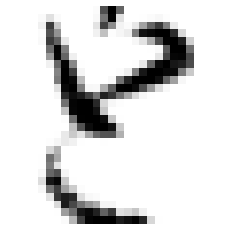

In [10]:
display_sample(X_tr[1])

## Preprocessing

We need our targets to be one hot encoded for the CNN

In [11]:
Y_tr_onehot = tf.keras.utils.to_categorical(Y_tr)
Y_val_onehot = tf.keras.utils.to_categorical(Y_val)

Let's convert everything to floats instead of ints for the neural network

In [12]:
X_tr = X_tr.astype('float32')
X_val = X_val.astype('float32')
Y_tr = Y_tr.astype('float32')
Y_val = Y_val.astype('float32')
Y_tr_onehot = Y_tr_onehot.astype('float32')
Y_val_onehot = Y_val_onehot.astype('float32')

Now let's standardize our features

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
X_tr_scaled = scaler.fit_transform(X_tr.reshape((X_tr.shape[0], 28*28))).reshape((X_tr.shape[0], 28, 28))
X_val_scaled = scaler.transform(X_val.reshape((X_val.shape[0], 28*28))).reshape((X_val.shape[0], 28, 28))

## Neural Network

In [15]:
from tensorflow.keras.layers import Flatten, Dense, Dropout

Let's build the model

In [16]:
tf.keras.backend.clear_session() # so that layer names don't keep incrementing

model_name = f"neural-{dataset}-{int(time.time())}"
model = tf.keras.models.Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(Y_tr_onehot.shape[1], activation='softmax')
], name=model_name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

model.summary()

Model: "neural-k49-1633888102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)     

2021-10-10 13:48:22.791757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
history = model.fit(
    X_tr_scaled,
    Y_tr,
    epochs=30,
    batch_size=128,
    validation_data=(X_val_scaled, Y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-2, patience=3)
    ]
)

Epoch 1/30


2021-10-10 13:48:23.055854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


1816/1816 [==============================] - 11s 6ms/step - loss: 1.7635 - sparse_categorical_accuracy: 0.5453 - val_loss: 1.0481 - val_sparse_categorical_accuracy: 0.7211
Epoch 2/30
1816/1816 [==============================] - 9s 5ms/step - loss: 0.8984 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.7629
Epoch 3/30
1816/1816 [==============================] - 10s 5ms/step - loss: 0.7708 - sparse_categorical_accuracy: 0.7908 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.7835
Epoch 4/30
1816/1816 [==============================] - 10s 6ms/step - loss: 0.7051 - sparse_categorical_accuracy: 0.8082 - val_loss: 0.7746 - val_sparse_categorical_accuracy: 0.7921
Epoch 5/30
1816/1816 [==============================] - 10s 6ms/step - loss: 0.6682 - sparse_categorical_accuracy: 0.8184 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.8003
Epoch 6/30
1816/1816 [==============================] - 11s 6ms/step - loss: 0.6341 - sparse_cate

In [18]:
model.evaluate(X_val_scaled,  Y_val, verbose=1)

1205/1205 [==============================] - 1s 1ms/step - loss: 0.5564 - sparse_categorical_accuracy: 0.8547A: 0s - loss: 0.5514 - sparse_categorical_accuracy: 0


[0.5563672780990601, 0.8546709418296814]

In [19]:
Y_preds = tf.nn.softmax(model.predict(X_val_scaled)).numpy()
Y_preds[0]

array([0.0197168 , 0.0197168 , 0.0197168 , 0.01971683, 0.0197168 ,
       0.0197168 , 0.0197168 , 0.01971681, 0.0197168 , 0.01971749,
       0.0197168 , 0.01971681, 0.01971682, 0.01971681, 0.01971683,
       0.01971682, 0.0197168 , 0.0197168 , 0.01971692, 0.05359198,
       0.0197168 , 0.01971681, 0.0197168 , 0.0197168 , 0.0197168 ,
       0.01971681, 0.0197168 , 0.0197168 , 0.0197168 , 0.0197168 ,
       0.0197168 , 0.01971682, 0.0197168 , 0.0197168 , 0.01971732,
       0.0197168 , 0.0197168 , 0.01971681, 0.01971682, 0.0197168 ,
       0.0197168 , 0.0197168 , 0.0197168 , 0.0197168 , 0.0197168 ,
       0.0197168 , 0.01971682, 0.0197168 , 0.0197168 ], dtype=float32)

In [20]:
conf_matrix_df = pd.DataFrame(tf.math.confusion_matrix(Y_val, [np.argmax(y) for y in Y_preds]).numpy(),
             index=[i for i in range(len(lookup_df['char']))],
             columns=[i for i in range(len(lookup_df['char']))]
)

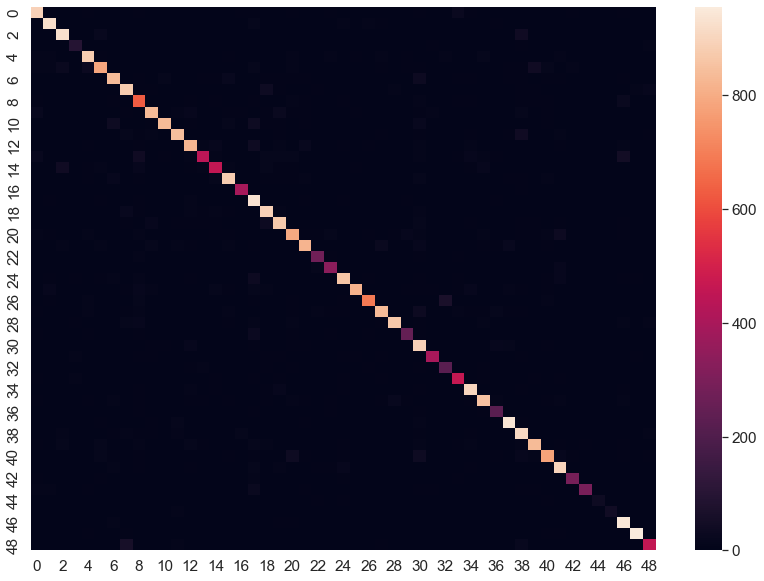

In [21]:
plt.figure(figsize=(14,10))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_df, annot=dataset=='kmnist', fmt="g")
plt.show()

2021-10-10 13:53:04.746193: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/neural-k49-1633888102/assets


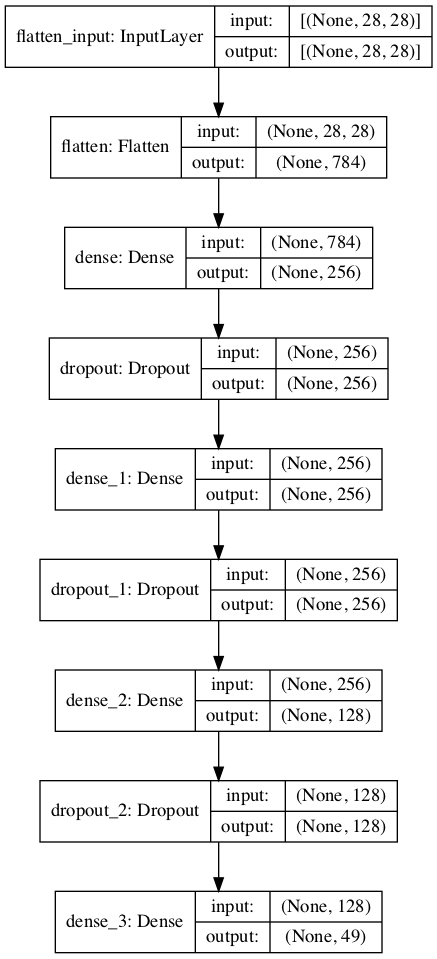

In [22]:
model.save(f'models/{model_name}')
tf.keras.utils.plot_model(model, f"models/{model_name}.png", show_shapes=True)